In [56]:
import numpy as np
import matplotlib.pyplot as plt
import ipytest
from itertools import combinations
ipytest.autoconfig()

In [57]:
def Point(x, y):
    return np.array([x,y])

def rotate90(x):
    return np.flip(x, -1)*np.array([-1, 1])

def is_even(n):
    return bool(n%2==0)

def zero_or_one(t: float) -> bool:
    return (t==0) or (t==1)

Vec = Point


class Polygon:

    def __init__(self, nodes):
        self.nodes = nodes
        if not self.is_polygon():
            raise ValueError('Not a polygon')

    def is_polygon(self):
        if len(set((tuple(node) for node in self.nodes)))<len(self.nodes):
            return False
        edges = list(self.edge_lines())
        for (i1, e1), (i2, e2) in combinations(enumerate(edges), 2):
            if (i2==i1+1) or (i1==0 and i2==len(edges)-1):
                continue 
            s, t = e1.intersection(e2)
            if 0<=s<=1 and 0<=t<=1:
                return False
        return True

    def is_convex(self):
        nodes = np.array(self.nodes + self.nodes[:1])
        edges = np.diff(nodes, axis=0)
        idx = np.array([ i % len(edges) for i in range(1, len(edges)+1) ])
        edges1 = edges[idx]
        sgn = (rotate90(edges) * edges1).sum(axis=1)
        return (min(sgn)*max(sgn)>=0)

    def is_inner(self, point, return_line=False):
        edges = list(self.edge_lines())
        while True:
            line = Line(point, np.random.normal(size=2))
            while any(line.is_parallel(edge) for edge in edges):
                line = Line(point, np.random.normal(size=2))
            t_values =[edge.intersection(line) for edge in edges]
            if all(not zero_or_one(t) for (t, s) in t_values):
                break
        points = [edge.point(t) for edge, (t, s) in zip(edges, t_values) if (0<t<1) and (s>=0)]
        is_inner = not is_even(len(points)) 
        if return_line:
            return is_inner, line, points
        return is_inner
    
    def edge_lines(self):
        for i, p in enumerate(self.nodes):
            next_p = self.nodes[(i+1) % len(self.nodes)]
            yield Line(p, next_p-p)

    def area(self):
        if self.is_convex():
            nodes = np.array(self.nodes)
            nodes = nodes-nodes[0]
            area = 0
            for v1, v2 in zip(nodes[1:], nodes[2:]):
                area += abs(v1[0]*v2[1]-v1[1]*v2[0])
            return area
        else:
            raise NotImplementedError
            
    def perimeter(self):
        total = 0
        for i, p in enumerate(self.nodes, 1):
            j = i % len(self.nodes)
            total += np.linalg.norm(self.nodes[j]-p)
        return total

    def draw(self, *args, fill=False, **kwargs):
        for i, p0 in enumerate(self.nodes):
            p1 = self.nodes[(i+1) % len(self.nodes)]
        x, y = np.concatenate((self.nodes, self.nodes[:1]), axis=0).T
        if fill:
            plt.fill(x, y, alpha=0.5)
        plt.plot(x, y, *args, **kwargs) 
        plt.axis('equal')
    
    def __repr__(self):
        return f'{type(self).__name__}({[tuple(x) for x in self.nodes]})'


class Rectangle(Polygon):
    
    def __init__(self, P1, P2, r):
        """
        Assuming that e is P1P2 rotated counterclockwise by 90 degree
        P1, P2, P2+r e, P1+re
        """
        v = rotate90(P2-P1)*r
        super(Rectangle, self).__init__([P1, P2, P2+v, P1+v])
        
    
class Square(Rectangle):

    def __init__(self, P1, P2):
        super(Square, self).__init__(P1, P2, 1)


class Line:
    
    def __init__(self, p: np.ndarray, e: np.ndarray):
        if (e==0).all():
            raise ValueError
        self.p = p
        self.e = e

    def is_parallel(self, other) -> bool:
        return np.linalg.det(np.stack((self.e, other.e))) == 0
    
    def intersection(self, other) -> float:
        if self.is_parallel(other):
            return np.array([np.Inf,np.Inf])
        a = np.column_stack((self.e, -other.e))
        b = other.p - self.p
        return np.linalg.solve(a, b)
    
    def point(self, t: float):
        return self.p + t*self.e
    
    def draw(self, half_line=False):
        if not half_line:
            plt.axline(self.p, self.p+self.e)
        else:
            x0, x1 = plt.xlim()
            y0, y1 = plt.ylim()
            for edge in [
                Line(Point(x0, y0), Vec(0,y1-y0)),
                Line(Point(x1, y0), Vec(0,y1-y0)),
                Line(Point(x0, y0), Vec(x1-x0,0)),
                Line(Point(x0, y1), Vec(x1-x0,0))                
            ]:
                t, s = self.intersection(edge)
                if t>0 and (0<=s<=1):
                    break
            p = edge.point(s)

            plt.plot(*np.stack((self.p, p), axis=1) )
            plt.xlim(x0, x1)
            plt.ylim(y0, y1)

In [58]:
%%ipytest

def test_is_p():
    p = Square(Point(0,0),Point(1,0))
    assert p.is_convex() == True
    assert p.is_polygon() == True
    with pt.raises(ValueError):
        Polygon([Point(0,0), Point(0,1), Point(1,0), Point(1,1)])
        Polygon([Point(0,0), Point(1,2), Point(2,3), Point(0,0)])
    p = Polygon(np.array([[0,0], [-1,3], [0,2], [1,3]]))
    assert p.is_convex() == False
    assert p.is_polygon() == True
    with pt.raises(NotImplementedError):
        p.area()
        
def test_Line():
    p0 = np.array([1,0])
    p1 = np.array([0,1])
    l0 = Line(p0, p1)
    l1 = Line(p1, p1)
    l2 = Line(p1, p0)
    
    assert l0.is_parallel(l1) == True
    assert l0.is_parallel(l2) == False
    assert tuple(l0.intersection(l2)) == (1, 1)

..                                                                                           [100%]
2 passed in 0.01s


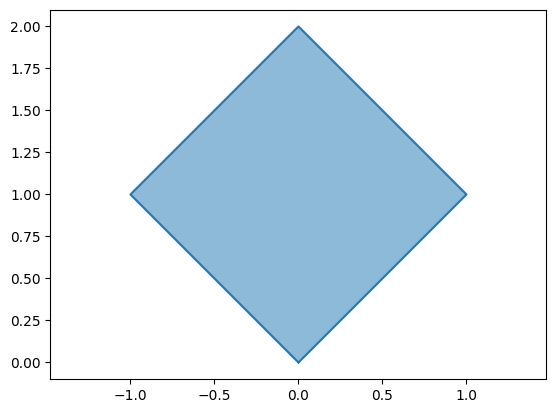

In [59]:
points = np.array([[0,0], [1,1]])
s = Square(points[0], points[1])
s.draw(fill=True)

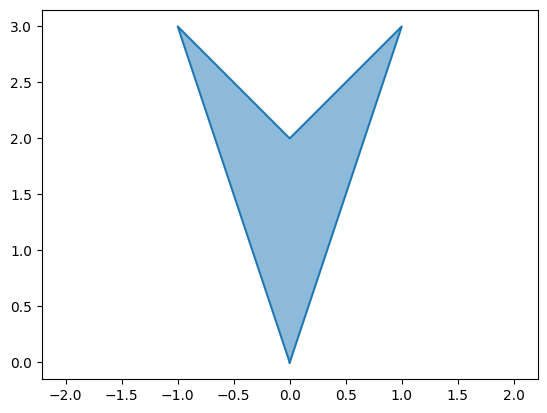

In [60]:
points = np.array([[0,0], [-1,3], [0,2], [1,3]])
s = Polygon(points)
s.draw(fill=True)